Imprtant libraries to install

```
pip install Flask
pip install Flask-WTF
pip install joblib
```

In [75]:
#imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

## Data and Model

In [148]:
ufc_fights = pd.read_csv('data/ufc_fight_data.csv')
ufc_stats = pd.read_csv('data/ufc_fight_stat_data.csv')
ufc_fighters = pd.read_csv('data/ufc_fighter_data.csv')

### Cleaning the data

In [149]:
# Create full name column and drop unnecessary columns
ufc_fighters['fighter_fullname'] = ufc_fighters['fighter_f_name'] + ' ' + ufc_fighters['fighter_l_name']
ufc_fighters.drop(['fighter_f_name', 'fighter_l_name', 'fighter_dob'], axis=1, inplace=True)

# Join datasets to get fight and fighter stats for each fight
ufc_df = ufc_fights.merge(ufc_stats, on='fight_id', how='outer') \
                   .merge(ufc_fighters, on='fighter_id', how='outer')

# Remove URL columns as they are not relevant
ufc_df.drop(['fight_url_x', 'fight_url_y', 'fighter_url'], axis=1, inplace=True)

# Replace 'NULL' and '--' in 'ctrl_time' and 'finish_time' columns with '0:00'
ufc_df['ctrl_time'] = ufc_df['ctrl_time'].replace(['NULL', '--'], '0:00')
ufc_df['finish_time'] = ufc_df['finish_time'].replace(['NULL', '--'], '0:00')

# Split 'finish_time' and 'ctrl_time' columns
finish_split = ufc_df['finish_time'].str.split(':', expand=True)
ctrl_split = ufc_df['ctrl_time'].str.split(':', expand=True)

# Convert 'finish_time' to total seconds
# Handle NaN values by filling with '0' or appropriate placeholder
finish_split = finish_split.fillna(0)
ufc_df['finish_time'] = (60 * finish_split[0].astype(float).fillna(0).astype(int) +
                         finish_split[1].astype(float).fillna(0).astype(int) + 
                         300 * ufc_df['finish_round'].astype(float).fillna(0).astype(int))

# Convert 'ctrl_time' to total seconds
# Handle NaN values by filling with '0' or appropriate placeholder
ctrl_split = ctrl_split.fillna(0)
ufc_df['ctrl_time'] = (60 * ctrl_split[0].astype(float).fillna(0).astype(int) +
                       ctrl_split[1].astype(float).fillna(0).astype(int))


In [150]:
display(ufc_df.head())

fight_id  event_id         referee     f_1     f_2  winner num_rounds  \
0    7218.0     664.0       Herb Dean  2976.0  2884.0  2884.0          5   
1    6922.0     639.0    Marc Goddard  2902.0  2976.0  2902.0          3   
2    6585.0     611.0      Mark Smith  3185.0  2976.0  2976.0          5   
3    6279.0     586.0       Herb Dean  1042.0  2976.0  2976.0          3   
4    6110.0     572.0  Jacob Montalvo  2728.0  2976.0  2976.0          3   

  title_fight weight_class gender    result  \
0           F  Lightweight      M    KO/TKO   
1           F  Lightweight      M  Decision   
2           F  Lightweight      M    KO/TKO   
3           F  Lightweight      M    KO/TKO   
4           F  Lightweight      M  Decision   

                                 result_details  finish_round  finish_time  \
0                    to    \r\n      Leg Injury           2.0          723   
1                                      Majority           3.0         1200   
2                     Punch to Head At Distance           5.0         1518   
3  Kick to Head At Distance\r\n      Wheel kick           3.0         1040   
4                                     Unanimous           3.0         1200   

   fight_stat_id  fighter_id  knockdowns  total_strikes_att  \
0        14436.0      2976.0         0.0               34.0   
1        13843.0      2976.0         0.0              169.0   
2        13169.0      2976.0         1.0              192.0   
3        12557.0      2976.0         0.0              123.0   
4        12219.0      2976.0         0.0              223.0   

   total_strikes_succ  sig_strikes_att  sig_strikes_succ  takedown_att  \
0                19.0             32.0              18.0           0.0   
1                97.0            169.0              97.0           0.0   
2                92.0            159.0              64.0           1.0   
3                66.0            123.0              66.0           0.0   
4               104.0            223.0             104.0           0.0   

   takedown_succ  submission_att  reversals  ctrl_time fighter_nickname  \
0            0.0             0.0        0.0          0           Ataman   
1            0.0             0.0        0.0          0           Ataman   
2            0.0             0.0        0.0        179           Ataman   
3            0.0             0.0        0.0          9           Ataman   
4            0.0             0.0        0.0          8           Ataman   

   fighter_height_cm  fighter_weight_lbs  fighter_reach_cm fighter_stance  \
0             172.72               155.0            180.34         Switch   
1             172.72               155.0            180.34         Switch   
2             172.72               155.0            180.34         Switch   
3             172.72               155.0            180.34         Switch   
4             172.72               155.0            180.34         Switch   

   fighter_w  fighter_l  fighter_d  fighter_nc_dq fighter_fullname  
0       12.0        3.0        0.0            NaN    Rafael Fiziev  
1       12.0        3.0        0.0            NaN    Rafael Fiziev  
2       12.0        3.0        0.0            NaN    Rafael Fiziev  
3       12.0        3.0        0.0            NaN    Rafael Fiziev  
4       12.0        3.0        0.0            NaN    Rafael Fiziev

We now have combined fight and fighter statistics for each fight, with two consecutive rows representing the same fight. Each row provides in-fight statistics (striking, takedowns, submissions, control, etc.) for one of the two fighters. For instance, the first two rows share the same fight_id (1) but have different fighter_fight_id values (1 and 2), representing Sean Daugherty and Scott Morris, respectively.

Next, we added opponent ID and opponent full name to each row. We used f_1 and f_2, which contain the ID numbers for both fighters. The opponent_id was assigned using the ID (f_1 or f_2) that did not match the fighter_id in the row. We then matched the opponent_id with the ufc_fighters dataframe to retrieve and assign the opponent's full name.

In [151]:
# Assuming ufc_df and ufc_fighters are already defined as pandas DataFrames
ufc_df['opponent_id'] = np.nan
ufc_df['opponent_fullname'] = np.nan

# Detecting rows where fighter ID data is not available
na_or_null = ufc_df['f_1'].isna()

# Setting opponent ID, then pulling the full name by matching the ID
ufc_df.loc[~na_or_null, 'opponent_id'] = np.where(ufc_df.loc[~na_or_null, 'f_1'] == ufc_df.loc[~na_or_null, 'fighter_id'],
                                                  ufc_df.loc[~na_or_null, 'f_2'], ufc_df.loc[~na_or_null, 'f_1'])

ufc_df['opponent_fullname'] = ufc_df['opponent_id'].map(ufc_fighters.set_index('fighter_id')['fighter_fullname'])

# Removing some irrelevant columns
ufc_df = ufc_df.drop(columns=['referee', 'f_1', 'f_2', 'num_rounds', 'weight_class', 'result_details',
                              'finish_round', 'fighter_nickname'])


In [152]:
display(ufc_df)

fight_id  event_id  winner title_fight gender    result  finish_time  \
0        7218.0     664.0  2884.0           F      M    KO/TKO          723   
1        6922.0     639.0  2902.0           F      M  Decision         1200   
2        6585.0     611.0  2976.0           F      M    KO/TKO         1518   
3        6279.0     586.0  2976.0           F      M    KO/TKO         1040   
4        6110.0     572.0  2976.0           F      M  Decision         1200   
...         ...       ...     ...         ...    ...       ...          ...   
16126       NaN       NaN     NaN         NaN    NaN       NaN            0   
16127       NaN       NaN     NaN         NaN    NaN       NaN            0   
16128       NaN       NaN     NaN         NaN    NaN       NaN            0   
16129       NaN       NaN     NaN         NaN    NaN       NaN            0   
16130       NaN       NaN     NaN         NaN    NaN       NaN            0   

       fight_stat_id  fighter_id  knockdowns  total_strikes_att  \
0            14436.0      2976.0         0.0               34.0   
1            13843.0      2976.0         0.0              169.0   
2            13169.0      2976.0         1.0              192.0   
3            12557.0      2976.0         0.0              123.0   
4            12219.0      2976.0         0.0              223.0   
...              ...         ...         ...                ...   
16126            NaN         8.0         NaN                NaN   
16127            NaN         5.0         NaN                NaN   
16128            NaN         4.0         NaN                NaN   
16129            NaN         3.0         NaN                NaN   
16130            NaN         1.0         NaN                NaN   

       total_strikes_succ  sig_strikes_att  sig_strikes_succ  takedown_att  \
0                    19.0             32.0              18.0           0.0   
1                    97.0            169.0              97.0           0.0   
2                    92.0            159.0              64.0           1.0   
3                    66.0            123.0              66.0           0.0   
4                   104.0            223.0             104.0           0.0   
...                   ...              ...               ...           ...   
16126                 NaN              NaN               NaN           NaN   
16127                 NaN              NaN               NaN           NaN   
16128                 NaN              NaN               NaN           NaN   
16129                 NaN              NaN               NaN           NaN   
16130                 NaN              NaN               NaN           NaN   

       takedown_succ  submission_att  reversals  ctrl_time  fighter_height_cm  \
0                0.0             0.0        0.0          0             172.72   
1                0.0             0.0        0.0          0             172.72   
2                0.0             0.0        0.0        179             172.72   
3                0.0             0.0        0.0          9             172.72   
4                0.0             0.0        0.0          8             172.72   
...              ...             ...        ...        ...                ...   
16126            NaN             NaN        NaN          0             190.50   
16127            NaN             NaN        NaN          0                NaN   
16128            NaN             NaN        NaN          0                NaN   
16129            NaN             NaN        NaN          0             175.26   
16130            NaN             NaN        NaN          0             187.96   

       fighter_weight_lbs  fighter_reach_cm fighter_stance  fighter_w  \
0                   155.0            180.34         Switch       12.0   
1                   155.0            180.34         Switch       12.0   
2                   155.0            180.34         Switch       12.0   
3                   155.0            180.34        

### Feature Engineering

In [153]:
# Creating an empty data frame where statistics will be stored for each fighter
my_stats_df = pd.DataFrame({'fighter_id': ufc_fighters['fighter_id']})

# Mutating relevant variables into a numeric type
ufc_df = ufc_df.astype({col: 'float' for col in ufc_df.columns if col in ['knockdowns', 'total_strikes_succ', 'total_strikes_att', 'sig_strikes_succ', 'sig_strikes_att', 'takedown_succ', 'takedown_att', 'submission_att', 'reversals', 'ctrl_time', 'finish_time']})

# Percentage accuracy function
def percentage_stat(a, b, c, d):
    for i in range(len(ufc_fighters)):
        fighter_data = ufc_df[ufc_df['fighter_id'] == ufc_fighters.loc[i, 'fighter_id']]
        if not fighter_data.empty:
            fighter_data[a] = fighter_data[b] / fighter_data[c]
            my_stats_df.loc[i, d] = fighter_data[a].mean()
            if pd.isna(my_stats_df.loc[i, d]):
                my_stats_df.loc[i, d] = 0
    return my_stats_df

# Average function
def average_stat(a, b):
    for i in range(len(ufc_fighters)):
        fighter_data = ufc_df[ufc_df['fighter_id'] == ufc_fighters.loc[i, 'fighter_id']]
        if not fighter_data.empty:
            my_stats_df.loc[i, a] = fighter_data[b].mean()
            if pd.isna(my_stats_df.loc[i, a]):
                my_stats_df.loc[i, a] = np.nan
    return my_stats_df

# Calculating percentage accuracy for strikes, significant strikes and takedowns
my_stats_df = percentage_stat('acc_strike', 'total_strikes_succ', 'total_strikes_att', 'strike_perc')
my_stats_df = percentage_stat('acc_sigstrike', 'sig_strikes_succ', 'sig_strikes_att', 'sigstrike_perc')
my_stats_df = percentage_stat('acc_td', 'takedown_succ', 'takedown_att', 'takedown_perc')

# Calculating average for strikes, significant strikes, knockdowns, takedowns, submission attempts, reversals, control and finish time
my_stats_df = average_stat('strike_avg', 'total_strikes_succ')
my_stats_df = average_stat('sig_strike_avg', 'sig_strikes_succ')
my_stats_df = average_stat('knockdown_avg', 'knockdowns')
my_stats_df = average_stat('takedown_avg', 'takedown_succ')
my_stats_df = average_stat('sub_avg', 'submission_att')
my_stats_df = average_stat('reversal_avg', 'reversals')
my_stats_df = average_stat('control_avg', 'ctrl_time')
my_stats_df = average_stat('finish_avg', 'finish_time')

# Calculating the average strikes and significant strikes per minute
my_stats_df['strike_per_minute'] = my_stats_df['strike_avg'] / (my_stats_df['finish_avg'] / 60)
my_stats_df['sig_strike_per_minute'] = my_stats_df['sig_strike_avg'] / (my_stats_df['finish_avg'] / 60)

# Calculating win percentage
my_stats_df['win_perc'] = ufc_fighters['fighter_w'] / ufc_fighters.iloc[:, 6:9].sum(axis=1)


C:\Users\Aryan\AppData\Local\Temp\ipykernel_5072\4059331331.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fighter_data[a] = fighter_data[b] / fighter_data[c]
C:\Users\Aryan\AppData\Local\Temp\ipykernel_5072\4059331331.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fighter_data[a] = fighter_data[b] / fighter_data[c]
C:\Users\Aryan\AppData\Local\Temp\ipykernel_5072\4059331331.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [154]:
display(my_stats_df.head())

fighter_id  strike_perc  sigstrike_perc  takedown_perc  strike_avg  \
0        4107     0.000000        0.000000       0.000000         NaN   
1        4106     0.478324        0.358447       0.000000   42.500000   
2        4105     0.000000        0.000000       0.000000         NaN   
3        4104     0.599985        0.503844       0.591667   17.277778   
4        4103     0.000000        0.000000       0.000000         NaN   

   sig_strike_avg  knockdown_avg  takedown_avg   sub_avg  reversal_avg  \
0             NaN            NaN           NaN       NaN           NaN   
1       29.500000       0.000000      0.000000  0.000000      0.000000   
2             NaN            NaN           NaN       NaN           NaN   
3        8.666667       0.222222      0.555556  0.222222      0.055556   
4             NaN            NaN           NaN       NaN           NaN   

   control_avg  finish_avg  strike_per_minute  sig_strike_per_minute  win_perc  
0     0.000000    0.000000                NaN                    NaN     0.625  
1    55.000000  838.000000           3.042959               2.112172     0.400  
2     0.000000    0.000000                NaN                    NaN     0.875  
3     6.833333  517.944444           2.001502               1.003969     0.400  
4     0.000000    0.000000                NaN                    NaN     1.000

In [155]:
# Create opponent stat dataframe
opp_stats_df = my_stats_df.copy()
opp_stats_df.columns = ['fighter_id'] + ['opp_' + col for col in my_stats_df.columns if col != 'fighter_id']

# Joining the dataframes
ufc_df = ufc_df.merge(my_stats_df, on='fighter_id', how='outer')
ufc_df = ufc_df.merge(opp_stats_df, left_on='opponent_id', right_on='fighter_id', how='outer', suffixes=('', '_opp'))

# Dropping the extra opponent_id column resulting from the join
ufc_df = ufc_df.drop(columns=['fighter_id_opp'])


In [156]:
display(ufc_df.head())

fight_id  event_id  winner title_fight gender    result  finish_time  \
0    7218.0     664.0  2884.0           F      M    KO/TKO        723.0   
1    6893.0     637.0  2884.0           F      M  Decision       1200.0   
2    5713.0     536.0  2145.0           F      M  Decision       1200.0   
3    6563.0     609.0  2884.0           F      M  Decision       1800.0   
4    6725.0     623.0  3296.0           F      M  Decision       1200.0   

   fight_stat_id  fighter_id  knockdowns  total_strikes_att  \
0        14436.0      2976.0         0.0               34.0   
1        13785.0       332.0         1.0              119.0   
2        11425.0      2145.0         1.0               93.0   
3        13126.0       350.0         1.0              264.0   
4        13450.0      3296.0         1.0              138.0   

   total_strikes_succ  sig_strikes_att  sig_strikes_succ  takedown_att  \
0                19.0             32.0              18.0           0.0   
1                62.0             97.0              40.0           1.0   
2                43.0             86.0              37.0           1.0   
3               110.0            247.0              95.0           8.0   
4                67.0            130.0              59.0           0.0   

   takedown_succ  submission_att  reversals  ctrl_time  fighter_height_cm  \
0            0.0             0.0        0.0        0.0             172.72   
1            0.0             0.0        0.0       32.0             190.50   
2            0.0             0.0        0.0        1.0             180.34   
3            1.0             0.0        0.0       99.0             170.18   
4            0.0             0.0        0.0       34.0             177.80   

   fighter_weight_lbs  fighter_reach_cm fighter_stance  fighter_w  fighter_l  \
0               155.0            180.34         Switch       12.0        3.0   
1               155.0            195.58       Southpaw       13.0        7.0   
2               155.0            182.88       Orthodox       12.0        4.0   
3               155.0            182.88       Orthodox       20.0        3.0   
4               155.0            182.88       Southpaw       22.0        5.0   

   fighter_d  fighter_nc_dq   fighter_fullname  opponent_id opponent_fullname  \
0        0.0            NaN      Rafael Fiziev       2884.0    Mateusz Gamrot   
1        0.0            NaN       Jalin Turner       2884.0    Mateusz Gamrot   
2        0.0            NaN  Guram Kutateladze       2884.0    Mateusz Gamrot   
3        0.0            NaN    Arman Tsarukyan       2884.0    Mateusz Gamrot   
4        1.0            NaN     Beneil Dariush       2884.0    Mateusz Gamrot   

   strike_perc  sigstrike_perc  takedown_perc  strike_avg  sig_strike_avg  \
0     0.598280        0.586087       0.375000   61.666667       57.222222   
1     0.532308        0.498195       0.555556   51.300000       41.600000   
2     0.480913        0.456272       0.158730   74.000000       66.666667   
3     0.615721        0.509584       0.395202   89.444444       52.000000   
4     0.543204        0.503130       0.351961   44.761905       32.904762   

   knockdown_avg  takedown_avg   sub_avg  reversal_avg  control_avg  \
0       0.222222      0.222222  0.000000      0.000000    51.444444   
1       0.500000      0.400000  0.700000      0.100000    65.600000   
2       0.333333      0.666667  0.000000      0.000000    61.000000   
3       0.222222      3.111111  0.000000      0.000000   317.333333   
4       0.285714      1.238095  0.571429      0.047619   227.761905   

    finish_avg  strike_per_minute  sig_strike_per_minute  win_perc  \
0  1001.333333           3.695073               3.428762  0.800000   
1   765.800000           4.019326               3.259337  0.650000   
2  1165.666667           3.808979               3.431513  0.750000   
3  1116.777778           4.805492               2.793752  0.869565   
4   839.285714           3.200000               2.352340 

In [157]:
# Calculating difference
ufc_df = ufc_df.assign(
    strike_diff = ufc_df['strike_avg'] - ufc_df['opp_strike_avg'],
    sig_strike_diff = ufc_df['sig_strike_avg'] - ufc_df['opp_sig_strike_avg'],
    spm_diff = ufc_df['strike_per_minute'] - ufc_df['opp_strike_per_minute'],
    sspm_diff = ufc_df['sig_strike_per_minute'] - ufc_df['opp_sig_strike_per_minute'],
    knockdown_diff = ufc_df['knockdown_avg'] - ufc_df['opp_knockdown_avg'],
    takedown_diff = ufc_df['takedown_avg'] - ufc_df['opp_takedown_avg'],
    sub_diff = ufc_df['sub_avg'] - ufc_df['opp_sub_avg'],
    control_diff = ufc_df['control_avg'] - ufc_df['opp_control_avg']
)

# Removing some columns which are now not useful and ordering the data frame as wanted
ufc_df = ufc_df.drop(columns=['fighter_d', 'fighter_l', 'fighter_nc_dq'])

display(ufc_df)


fight_id  event_id  winner title_fight gender    result  finish_time  \
0        7218.0     664.0  2884.0           F      M    KO/TKO        723.0   
1        6893.0     637.0  2884.0           F      M  Decision       1200.0   
2        5713.0     536.0  2145.0           F      M  Decision       1200.0   
3        6563.0     609.0  2884.0           F      M  Decision       1800.0   
4        6725.0     623.0  3296.0           F      M  Decision       1200.0   
...         ...       ...     ...         ...    ...       ...          ...   
17821       NaN       NaN     NaN         NaN    NaN       NaN          NaN   
17822       NaN       NaN     NaN         NaN    NaN       NaN          NaN   
17823       NaN       NaN     NaN         NaN    NaN       NaN          NaN   
17824       NaN       NaN     NaN         NaN    NaN       NaN          NaN   
17825       NaN       NaN     NaN         NaN    NaN       NaN          NaN   

       fight_stat_id  fighter_id  knockdowns  total_strikes_att  \
0            14436.0      2976.0         0.0               34.0   
1            13785.0       332.0         1.0              119.0   
2            11425.0      2145.0         1.0               93.0   
3            13126.0       350.0         1.0              264.0   
4            13450.0      3296.0         1.0              138.0   
...              ...         ...         ...                ...   
17821            NaN         NaN         NaN                NaN   
17822            NaN         NaN         NaN                NaN   
17823            NaN         NaN         NaN                NaN   
17824            NaN         NaN         NaN                NaN   
17825            NaN         NaN         NaN                NaN   

       total_strikes_succ  sig_strikes_att  sig_strikes_succ  takedown_att  \
0                    19.0             32.0              18.0           0.0   
1                    62.0             97.0              40.0           1.0   
2                    43.0             86.0              37.0           1.0   
3                   110.0            247.0              95.0           8.0   
4                    67.0            130.0              59.0           0.0   
...                   ...              ...               ...           ...   
17821                 NaN              NaN               NaN           NaN   
17822                 NaN              NaN               NaN           NaN   
17823                 NaN              NaN               NaN           NaN   
17824                 NaN              NaN               NaN           NaN   
17825                 NaN              NaN               NaN           NaN   

       takedown_succ  submission_att  reversals  ctrl_time  fighter_height_cm  \
0                0.0             0.0        0.0        0.0             172.72   
1                0.0             0.0        0.0       32.0             190.50   
2                0.0             0.0        0.0        1.0             180.34   
3                1.0             0.0        0.0       99.0             170.18   
4                0.0             0.0        0.0       34.0             177.80   
...              ...             ...        ...        ...                ...   
17821            NaN             NaN        NaN        NaN                NaN   
17822            NaN             NaN        NaN        NaN                NaN   
17823            NaN             NaN        NaN        NaN                NaN   
17824            NaN             NaN        NaN        NaN                NaN   
17825            NaN             NaN        NaN        NaN                NaN   

       fighter_weight_lbs  fighter_reach_cm fighter_stance  fighter_w  \
0                   155.0            180.34         Switch       12.0   
1                   155.0            195.58       Southpaw       13.0   
2                   155.0            182.88       Orthodox       12.0   
3                   155.0            182.88       O

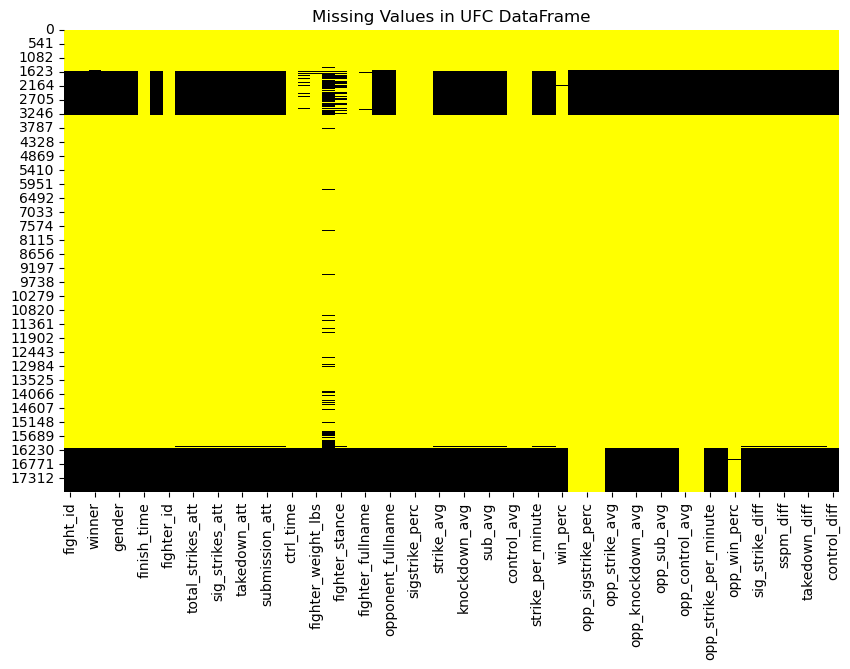

(14252, 64)


In [158]:
# Visualizing the location of NA values
plt.figure(figsize=(10, 6))
sns.heatmap(ufc_df.isnull(), cbar=False, cmap=['yellow', 'black'])
plt.title('Missing Values in UFC DataFrame')
plt.show()

# Impute missing values in fighter_reach_cm with average
ufc_df['fighter_reach_cm'] = ufc_df['fighter_reach_cm'].fillna(ufc_df['fighter_reach_cm'].mean())

# Replacing NULL values with 'Unknown' in fighter_stance column, then changing variable type to category
ufc_df['fighter_stance'] = ufc_df['fighter_stance'].replace('NULL', 'Unknown')
ufc_df['fighter_stance'] = ufc_df['fighter_stance'].astype('category')
ufc_df['winner.y'] = np.where(ufc_df['winner'] == ufc_df['fighter_id'], 'T', 'F')

# Convert other columns to categorical type
categorical_columns = ['fighter_stance', 'title_fight', 'winner.y', 'gender', 'result']
ufc_df[categorical_columns] = ufc_df[categorical_columns].apply(lambda x: x.astype('category'))

# Drop rows with NA values after imputing missing values
ufc_df = ufc_df.dropna()

# Check dimensions of the DataFrame
print(ufc_df.shape)  # This should output the new dimensions of the DataFrame


In [165]:
# Calculating wins with the UFC
full_df = pd.DataFrame()
for name in ufc_df['fighter_fullname'].unique():
    fighter_df = ufc_df[ufc_df['fighter_fullname'] == name].copy()
    for i in range(len(fighter_df)):
        fighter_df.loc[i, 'fighter_w'] = sum(fighter_df.loc[:i-1, 'winner.y'] == 'T')
    full_df = pd.concat([full_df, fighter_df])

full_df = full_df.dropna()
df = full_df.copy()  # Actual fighter_w

In [167]:
display(df.head())

fight_id  event_id  winner title_fight gender    result  finish_time  \
0     7218.0     664.0  2884.0           F      M    KO/TKO        723.0   
8     6922.0     639.0  2902.0           F      M  Decision       1200.0   
20    6585.0     611.0  2976.0           F      M    KO/TKO       1518.0   
54    6279.0     586.0  2976.0           F      M    KO/TKO       1040.0   
61    6110.0     572.0  2976.0           F      M  Decision       1200.0   

    fight_stat_id  fighter_id  knockdowns  total_strikes_att  \
0         14436.0      2976.0         0.0               34.0   
8         13843.0      2976.0         0.0              169.0   
20        13169.0      2976.0         1.0              192.0   
54        12557.0      2976.0         0.0              123.0   
61        12219.0      2976.0         0.0              223.0   

    total_strikes_succ  sig_strikes_att  sig_strikes_succ  takedown_att  \
0                 19.0             32.0              18.0           0.0   
8                 97.0            169.0              97.0           0.0   
20                92.0            159.0              64.0           1.0   
54                66.0            123.0              66.0           0.0   
61               104.0            223.0             104.0           0.0   

    takedown_succ  submission_att  reversals  ctrl_time  fighter_height_cm  \
0             0.0             0.0        0.0        0.0             172.72   
8             0.0             0.0        0.0        0.0             172.72   
20            0.0             0.0        0.0      179.0             172.72   
54            0.0             0.0        0.0        9.0             172.72   
61            0.0             0.0        0.0        8.0             172.72   

    fighter_weight_lbs  fighter_reach_cm fighter_stance  fighter_w  \
0                155.0            180.34         Switch        0.0   
8                155.0            180.34         Switch        6.0   
20               155.0            180.34         Switch       12.0   
54               155.0            180.34         Switch       12.0   
61               155.0            180.34         Switch       12.0   

   fighter_fullname  opponent_id opponent_fullname  strike_perc  \
0     Rafael Fiziev       2884.0    Mateusz Gamrot      0.59828   
8     Rafael Fiziev       2902.0    Justin Gaethje      0.59828   
20    Rafael Fiziev       3185.0  Rafael Dos Anjos      0.59828   
54    Rafael Fiziev       1042.0      Brad Riddell      0.59828   
61    Rafael Fiziev       2728.0       Bobby Green      0.59828   

    sigstrike_perc  takedown_perc  strike_avg  sig_strike_avg  knockdown_avg  \
0         0.586087          0.375   61.666667       57.222222       0.222222   
8         0.586087          0.375   61.666667       57.222222       0.222222   
20        0.586087          0.375   61.666667       57.222222       0.222222   
54        0.586087          0.375   61.666667       57.222222       0.222222   
61        0.586087          0.375   61.666667       57.222222       0.222222   

    takedown_avg  sub_avg  reversal_avg  control_avg   finish_avg  \
0       0.222222      0.0           0.0    51.444444  1001.333333   
8       0.222222      0.0           0.0    51.444444  1001.333333   
20      0.222222      0.0           0.0    51.444444  1001.333333   
54      0.222222      0.0           0.0    51.444444  1001.333333   
61      0.222222      0.0           0.0    51.444444  1001.333333   

    strike_per_minute  sig_strike_per_minute  win_perc  opp_strike_perc  \
0            3.695073               3.428762       0.8         0.608018   
8            3.695073               3.428762       0.8         0.603987   
20           3.695073               3.428762       0.8         0.549161   
54           3.695073               3.428762       0.8         0.594304   
61           3.695073               3.428762       0.8         0.568123   

    opp_sigstrike_perc  opp_takedown_perc  opp_strike_avg  opp_sig_stri

In [169]:
np.random.seed(777)

# Finding fights which have stats for both fighters (some only have stats for 1)
duplicated_fights = ufc_df['fight_id'].duplicated() | ufc_df['fight_id'].duplicated(keep='last')

# Creating dataframe of fights which are not duplicated
df_unique_fights = ufc_df[~duplicated_fights].copy()
df_duplicated_fights = ufc_df[duplicated_fights].copy()  # Automatically using those fights for our final dataframe

# Getting random sample from remaining fights, ensuring TRUE and FALSE are equally spread
unique_fight_ids = df_duplicated_fights['fight_id'].unique()
sample = np.random.choice(unique_fight_ids, size=int(len(ufc_df['fight_id'].unique())/2) - sum(df_unique_fights['winner.y'] == 'T'), replace=False)

df_duplicated_winners = df_duplicated_fights[df_duplicated_fights['winner.y'] == 'T'].copy()
df_duplicated_winners = df_duplicated_winners[df_duplicated_winners['fight_id'].isin(sample)]

df_duplicated_losers = df_duplicated_fights[df_duplicated_fights['winner.y'] == 'F'].copy()
df_duplicated_losers = df_duplicated_losers[~df_duplicated_losers['fight_id'].isin(sample)]

df = pd.concat([df_unique_fights, df_duplicated_winners, df_duplicated_losers]).sort_values(by='fight_id')

# Checking we have an equal spread
print(df.shape)  
print(sum(df['winner.y'] == 'T')) 

# Removing some final columns
df = df.drop(columns=['event_id', 'total_strikes_att', 'total_strikes_succ', 'sig_strikes_att', 'sig_strikes_succ',
                      'knockdowns', 'takedown_att', 'takedown_succ', 'submission_att', 'reversals', 'ctrl_time',
                      'finish_time'])

display(df.head())


(7158, 64)
3579


fight_id  winner title_fight gender      result  fight_stat_id  \
16128       1.0  1593.0           F      M  Submission            2.0   
16122       2.0   640.0           F      M  Submission            4.0   
16126       3.0  1060.0           F      M      KO/TKO            6.0   
16127       5.0   141.0           F      M      KO/TKO           10.0   
16110       6.0  1324.0           F      M  Submission           12.0   

       fighter_id  fighter_height_cm  fighter_weight_lbs  fighter_reach_cm  \
16128      1593.0             177.80               210.0        183.041512   
16122       640.0             187.96               225.0        183.041512   
16126      1060.0             182.88               210.0        183.041512   
16127       141.0             177.80               170.0        183.041512   
16110      1324.0             190.50               260.0        183.041512   

      fighter_stance  fighter_w fighter_fullname  opponent_id  \
16128       Orthodox        2.0     Scott Morris       3295.0   
16122       Orthodox       20.0    Patrick Smith        108.0   
16126       Orthodox        2.0    Johnny Rhodes       2038.0   
16127       Southpaw        1.0     Orlando Wiet       1962.0   
16110       Southpaw        9.0    Remco Pardoel       2051.0   

        opponent_fullname  strike_perc  sigstrike_perc  takedown_perc  \
16128      Sean Daugherty     1.000000        1.000000            0.5   
16122          Ray Wizard     0.722513        0.686275            0.5   
16126       David Levicki     0.619180        0.513260            1.0   
16127    Robert Lucarelli     0.723810        0.583333            0.0   
16110  Alberta Cerra Leon     0.870130        0.722222            1.0   

       strike_avg  sig_strike_avg  knockdown_avg  takedown_avg   sub_avg  \
16128         1.0        0.500000       0.000000      0.500000  0.500000   
16122         7.4        5.200000       0.200000      0.400000  0.600000   
16126        33.0        9.333333       0.333333      0.333333  0.333333   
16127         8.0        4.500000       0.000000      0.000000  0.000000   
16110         9.4        2.600000       0.000000      0.800000  0.800000   

       reversal_avg  control_avg  finish_avg  strike_per_minute  \
16128           0.0          0.0       325.0           0.184615   
16122           0.0          0.0       360.0           1.233333   
16126           0.0          0.0       429.0           4.615385   
16127           0.0          0.0       429.5           1.117579   
16110           0.0          0.0       520.6           1.083365   

       sig_strike_per_minute  win_perc  opp_strike_perc  opp_sigstrike_perc  \
16128               0.092308  0.666667         0.200000            0.000000   
16122               0.866667  0.540541         1.000000            1.000000   
16126               1.305361  0.666667         0.931373            0.800000   
16127               0.628638  0.166667         0.333333            0.333333   
16110               0.299654  0.562500         0.818182            0.333333   

       opp_takedown_perc  opp_strike_avg  opp_sig_strike_avg  \
16128                0.0             1.0                 0.0   
16122                0.0             2.0                 1.0   
16126                0.0            95.0                 4.0   
16127                1.0             2.0                 2.0   
16110                0.0             9.0                 1.0   

       opp_knockdown_avg  opp_takedown_avg  opp_sub_avg  opp_reversal_avg  \
16128                0.0               0.0          0.0               0.0   
16122                0.0               0.0          0.0               0.0   
16126                0.0               0.0          0.0               0.0   
16127                0.0               1.0          1.0               0.0   
16110                0.0               0.0          0.0               0.0   

       opp_control_avg  opp_finish_avg  opp_strike_per_minute  \
16128              0.

Writeback final cleaned data to csv.

In [170]:
df.to_csv("data/ufc_final.csv", index=False)

============================================================================

In [ ]:
df = pd.read_csv("data/cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)
sample_df.head()

wid reflection_period  \
hmid                            
27676   206               24h   
27678    45               24h   
27697   498               24h   
27705  5732               24h   
27715  2272               24h   

                                             original_hm  \
hmid                                                       
27676  We had a serious talk with some friends of our...   
27678                            I meditated last night.   
27697  My grandmother start to walk from the bed afte...   
27705  I picked my daughter up from the airport and w...   
27715        when i received flowers from my best friend   

                                                  moment  modified  \
hmid                                                                 
27676  We had a serious talk with some friends of our...      True   
27678                            I meditated last night.      True   
27697  My grandmother start to walk from the bed afte...      True   
27705  I picked my daughter up from the airport and w...      True   
27715        when i received flowers from my best friend      True   

       num_sentence     target predicted_category  
hmid                                               
27676             2    bonding            bonding  
27678             1    leisure            leisure  
27697             1  affection          affection  
27705             1    bonding          affection  
27715             1    bonding            bonding

In [ ]:
sample_df["target"].value_counts()

target
affection           4810
achievement         4276
bonding             1750
enjoy_the_moment    1514
leisure             1306
nature               252
exercise             217
Name: count, dtype: int64

In [ ]:
train_df, test_df = train_test_split(sample_df, test_size=0.2, random_state=123)
X_train_happy, y_train_happy = train_df["moment"], train_df["target"]
X_test_happy, y_test_happy = test_df["moment"], test_df["target"]

In [ ]:
pipe_lr = make_pipeline(
    CountVectorizer(stop_words="english"),
    LogisticRegression(max_iter=2000),
)

In [ ]:
pipe_lr.fit(X_train_happy, y_train_happy);

Saving the model:

In [ ]:
import joblib

with open("web_application/moment_predictor.joblib", "wb") as f:
    joblib.dump(pipe_lr, f)

## Running the application

In [54]:
%run -i "web_application/app.py"

predictform
 * Serving Flask app 'app'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [19/May/2024 00:19:28] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2024 00:19:28] "GET /static/style.css HTTP/1.1" 304 -
